## CIFAR-10 Image Classification using Convolutional Neural Networks
We are going to be using pytorch, a deep learning framework, and utilize certain modules:
- <span style="color: orange;">**torch.nn**</span>: Module for building neural networks
- <span style="color: orange;">**torch.optim**</span>: Module for optimization algorithms (e.g. Adam, SGD)
- <span style="color: orange;">**torchvision**</span>: Module that provides our dataset and data transformation utilities.
- <span style="color: orange;">**DataLoader**</span> from torch.utils.data: Module for loading the dataset

Other useful libraries:
- <span style="color: orange;">**matplotlib**</span>: Plotting & Calculations
- <span style="color: orange;">**numpy**</span>: Plotting & Calculations
- <span style="color: orange;">**time**</span>: To measure the training duration

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import time

# Set random seed for reproducibility
torch.manual_seed(42)

# The variable "device" specifies the computational device 
# This is where we run our neural network on (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Data Preprocessing
Transformations imposed on the training data improve generalization, the steps go as follows:
- Cropping 
- Flipping
- Conversion to tensor 
- Normalization

However, when testing we only normalize the data:
- Conversion to tensor 
- Normalization

### Conversion to tensor

**Converts the input image** from a PIL (Python Imaging Library) image or NumPy array into a PyTorch tensor
- <span style="color: orange;">**Rescales**</span> pixel values from the range [0, 255] (for images) to [0, 1] by dividing by 255.
- <span style="color: orange;">**Rearranges the image dimensions**</span> from (Height × Width × Channels) to (Channels × Height × Width) to match PyTorch's convention.

The Tensor format is required for performing computations in PyTorch models.

### Normalization
For each channel (R, G, B), it subtracts the corresponding mean (0.4914, 0.4822, 0.4465) and divides by the corresponding standard deviation (0.2023, 0.1994, 0.2010):
$$Normalized Value = \frac{Pixel Value - Mean}{Standard Deviation}$$
Normalization helps standardize the input data, which improves the convergence of the model during training.

In [2]:
# Data Preprocessing
# Tranformations for the training dataset
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4), # Randomly crops image with padding
    transforms.RandomHorizontalFlip(), # Randomly flips image horizontally
    transforms.ToTensor(), # Converts image to tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
# Tranformations for the test dataset
transform_test = transforms.Compose([
    transforms.ToTensor(), # Converts image to tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

_Loading dataset and applying previous transformations..._

In [3]:
# Load CIFAR-10 training dataset
trainset = torchvision.datasets.CIFAR10(root='./cifar-10-batches-py', train=True,
                                      download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128,
                        shuffle=True, num_workers=2)

# Load CIFAR-10 test dataset
testset = torchvision.datasets.CIFAR10(root='./cifar-10-batches-py', train=False,
                                     download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=100,
                       shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


### Dataset familiarization
Fetch example images from the training dataset, along with the class they belong to.

Some example images:


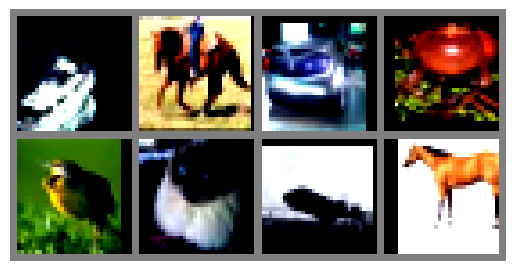

Labels:
  ship  horse    car   frog
  bird    cat  plane  horse


In [ ]:
# Specify the classes
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# Visualization function
def imshow(img):
    img = img / 2 + 0.5  # reverse normalization
    npimg = img.numpy() # convert to numpy array
    npimg = np.clip(npimg, 0, 1)  # clip values to the valid range [0, 1]
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # transpose to (H, W, C) for correct display
    plt.axis('off')
    plt.show()

# Fetch some random images from the training dataset
dataiter = iter(trainloader)
images, labels = next(dataiter)
print('Some example images:')
imshow(torchvision.utils.make_grid(images[:8], nrow=4)) # select first 8 images, 4 images per row
nrow = 4
n_images = 8
print("Labels:")
for i in range(0, n_images, nrow):
    print(" ".join(f"{classes[labels[j]]:>6}" for j in range(i, min(i + nrow, n_images))))

### Convolutional Neural Networks
The CNN class defines the model architecture. There are 3 steps we have to go through:
- Convolutional layers
- Fully connected layers
- Forward 

In [6]:
# Define the CNN architecture
class CNN(nn.Module):
    # Initialize the architecture
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(3, 32, 3, padding=1), # 3 input channels (R G B), 32 output channels, 3x3 kernel, 1 padding
            nn.BatchNorm2d(32), # normalize the output of the previous layer to have a mean = 0 and standard deviation = 1
            nn.ReLU(), # ReLU activation function: f(x) = max(0, x)

            # Second convolutional layer
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(2, 2),  # for each 2x2 window, take the maximum value
            nn.Dropout(0.25), # set 25% of the neurons to zero

            # Third convolutional layer
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Fourth convolutional layer
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            # Fifth convolutional layer
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            # Sixth convolutional layer
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
        )
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512), # First fully connected layer
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10) # Final fully connected layer, 512 input features, 10 output features (classes)
        )

    # Define the forward pass
    def forward(self, x):
        x = self.conv_layers(x) # Pass input through convolutional layers
        x = x.view(x.size(0), -1) # Flatten the output of the convolutional layers
        x = self.fc_layers(x) # Pass through fully connected layers
        return x

### Loss Function
Calculates how well the model is doing by calculating the difference between the model's predictions and the actual target values(ground truth). The lower the loss the better the predictions. For classification problems we use:
- Cross-Entropy Loss
    - Measures difference between predicted probability distributions and actual classes
    - Common for categorizing into discrete classes
### Optimizer
Adam (Adaptive Moment Estimation) is an optimization algorithm which updates the model's weights to minimize the loss function.
### Learning Rate Scheduler
Dynamically adjusts the learning rate during training:
- Reduces learning rate when the performance peaks.
- patience=3: Waits 3 epochs without improvement before triggering
- factor=0.5: Reduces learning rate by half when triggered
- min: monitors a metric and reduces learning rate when it stops decreasing
>scheduler.step(test_loss) # When the scheduler gets called later in the code's main loop it is set as to minimize the test loss

Example:
1. Starting LR = 0.001
2. After plateau (no improvement for 3 epochs):
3. New LR = 0.001 * 0.5 = 0.0005
4. After another plateau:
5. New LR = 0.0005 * 0.5 = 0.00025

In [7]:
# Initialize the model
model = CNN().to(device) # send model to device for training
criterion = nn.CrossEntropyLoss() # Loss function
optimizer = optim.Adam(model.parameters(), lr=0.001) # Optimizer
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5) # Learning rate scheduler

### Training function
The training process entails 4 basic steps:
- <span style="color: orange;">**Forward pass**</span>: We pass the images through the CNN neural network.
- <span style="color: orange;">**Loss Calculation**</span>: We calculate how far the model's predictions are from the ground truth.
- <span style="color: orange;">**Backward pass**</span>: We use back-propagation to compute the gradient of the loss function with respect to each weight in the network. This represents how much each weight contributed to the error.
- <span style="color: orange;">**Optimization**</span>: Using the Adam optimizer we update the weights in order to minimize loss.

In [8]:
# Training function
def train(model, trainloader, criterion, optimizer, device):
    model.train() # Set model to training mode
    running_loss = 0.0 #
    correct = 0 # Number of correctly predicted images
    total = 0 # Total number of images
    
    # Iterate over the training dataset
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device) #data[0] is the image, data[1] is the label
        
        optimizer.zero_grad() # Reset the gradients of model parameters
        outputs = model(inputs) # Forward pass
        loss = criterion(outputs, labels) # Calculate loss
        loss.backward() # Backward pass
        optimizer.step() # Update weights
        
        # Track training statistics
        running_loss += loss.item() # Add loss to running loss
        _, predicted = outputs.max(1) # Get the class index with the highest probability
        total += labels.size(0) # Add batch size to total
        correct += predicted.eq(labels).sum().item() # Add number of correct predictions to correct
        
        # Print statistics every 100 mini-batches
        if i % 100 == 99:
            print(f'[{i + 1}] loss: {running_loss / 100:.3f} | acc: {100.*correct/total:.2f}%')
            running_loss = 0.0 # Reset running loss
    
    return 100. * correct / total

### Evaluation function
The evaluation process entails 3 steps:
- <span style="color: orange;">**Forward pass**</span> 
- <span style="color: orange;">**Loss Calculation**</span> 

There is no need to <span style="color: orange;">**Backward pass**</span> or <span style="color: orange;">**Optimize**</span> our neural network since we are only testing its final state.

In [9]:
# Evaluation function
def evaluate(model, testloader, criterion, device):
    model.eval() # Set model to evaluation mode
    test_loss = 0 # Total loss
    correct = 0 # Number of correctly predicted images
    total = 0 # Total number of images
    
    with torch.no_grad(): # Disable gradient calculation
        # Iterate over the test dataset
        for data in testloader: 
            images, labels = data[0].to(device), data[1].to(device) #data[0] is the image, data[1] is the label
            outputs = model(images) # Forward pass
            loss = criterion(outputs, labels) # Calculate loss
            
            # Track test statistics
            test_loss += loss.item() # Add loss to test loss
            _, predicted = outputs.max(1) # Get the class index with the highest probability
            total += labels.size(0) # Add batch size to total
            correct += predicted.eq(labels).sum().item() # Add number of correct predictions to correct
    
    accuracy = 100. * correct / total # Calculate accuracy
    avg_loss = test_loss / len(testloader) # Calculate average loss
    print(f'Test set: Average loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')
    return accuracy, avg_loss

### Training Loop
This is our main loop. Here we utilize the aforementioned functions to:
- <span style="color: orange;">**Train**</span>
- <span style="color: orange;">**Evaluate**</span>
- <span style="color: orange;">**Benchmark**</span>
- <span style="color: orange;">**Save**</span>

our neural network.

In [10]:
# Training loop
num_epochs = 5 # Number of epochs
best_acc = 0 # Best accuracy
train_acc_history = [] # Training accuracy history
test_acc_history = [] # Test accuracy history

print(f"Training on {device}") # Print device
start_time = time.time() # Start time

# Iterate over the epochs
for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}') # Print epoch
    
    # Train and evaluate the model
    train_acc = train(model, trainloader, criterion, optimizer, device)
    test_acc, test_loss = evaluate(model, testloader, criterion, device)
    
    # Track accuracy history
    train_acc_history.append(train_acc)
    test_acc_history.append(test_acc)
    
    # Learning rate scheduling
    scheduler.step(test_loss) # Adjust learning rate based on loss
    
    # Save best model
    if test_acc > best_acc:
        print(f'Saving best model with accuracy: {test_acc:.2f}%') # Print current best accuracy
        # Save the model with the best accuracy in the filename
        torch.save(model.state_dict(), f'./cifar10_acc_{test_acc:.2f}.pth')
        best_acc = test_acc

# Calculate training time
training_time = time.time() - start_time # Calculate training time
print(f'\nTraining completed in {training_time/60:.2f} minutes') # Print training time
print(f'Best accuracy: {best_acc:.2f}%') # Print final best accuracy

Training on cpu

Epoch 1/5
[100] loss: 2.160 | acc: 22.41%
[200] loss: 1.798 | acc: 27.06%
[300] loss: 1.640 | acc: 30.77%
Test set: Average loss: 1.3982, Accuracy: 46.86%
Saving best model with accuracy: 46.86%

Epoch 2/5
[100] loss: 1.469 | acc: 45.88%
[200] loss: 1.371 | acc: 47.72%
[300] loss: 1.290 | acc: 49.68%
Test set: Average loss: 1.0824, Accuracy: 61.09%
Saving best model with accuracy: 61.09%

Epoch 3/5
[100] loss: 1.181 | acc: 58.17%
[200] loss: 1.148 | acc: 58.70%
[300] loss: 1.110 | acc: 59.53%
Test set: Average loss: 1.0197, Accuracy: 64.15%
Saving best model with accuracy: 64.15%

Epoch 4/5
[100] loss: 1.041 | acc: 63.37%
[200] loss: 1.041 | acc: 63.47%
[300] loss: 1.006 | acc: 63.97%
Test set: Average loss: 0.8148, Accuracy: 70.70%
Saving best model with accuracy: 70.70%

Epoch 5/5
[100] loss: 0.962 | acc: 66.15%
[200] loss: 0.932 | acc: 66.97%
[300] loss: 0.929 | acc: 67.15%
Test set: Average loss: 0.8693, Accuracy: 69.72%

Training completed in 30.94 minutes
Best ac

### Visualization

<Figure size 640x480 with 0 Axes>

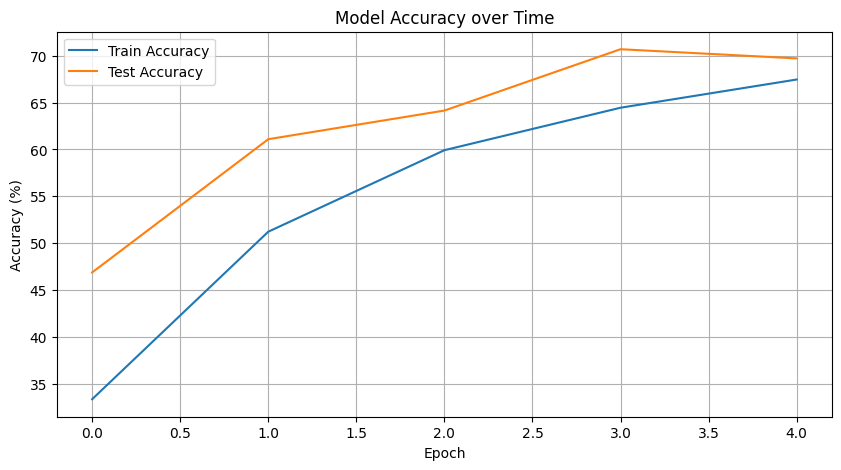

Test set: Average loss: 1.3982, Accuracy: 46.86%

Some test predictions:


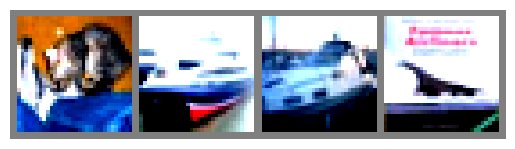

Ground Truth:   cat  ship  ship plane
Predicted:   cat   car  ship  ship


In [ ]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(test_acc_history, label='Test Accuracy')
plt.title('Model Accuracy over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

# Load best model and evaluate on test set
model.load_state_dict(torch.load('./cifar10_acc_46.86.pth', weights_only=True))
test_acc, _ = evaluate(model, testloader, criterion, device)

# Visualization of predictions
# model.eval()
# dataiter = iter(testloader)
# images, labels = next(dataiter)
# images = images.to(device)
# labels = labels.to(device)

# outputs = model(images)
# _, predicted = torch.max(outputs, 1)

# # Show some test images and their predictions
# print('\nSome test predictions:')
# imshow(torchvision.utils.make_grid(images[:4].cpu()))
# print('Ground Truth:', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
# print('Predicted:', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))



Per-class Accuracy

In [15]:
# Compute per-class accuracy
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print('\nPer-class accuracy:')
for i in range(10):
    print(f'{classes[i]:>5s}: {100 * class_correct[i] / class_total[i]:.2f}%')


Per-class accuracy:
plane: 68.18%
  car: 59.38%
 bird: 21.05%
  cat: 11.63%
 deer: 51.02%
  dog: 65.62%
 frog: 47.17%
horse: 62.50%
 ship: 10.42%
truck: 75.86%


### Results
```
Output:
Training completed in 607.96 minutes
Best accuracy: 91.27%
Test set: Average loss: 0.3188, Accuracy: 91.27%

Some test predictions:
Ground Truth:   cat  ship  ship plane
Predicted:   cat  ship  ship plane
```

Per-class accuracy:
|Class | Accuracy|
|------|---------|
|plane | 97.73%  |
|car   | 100.00% |
|bird  | 78.95%  |
|cat   | 76.74%  |
|deer  | 91.84%  |
|dog   | 87.50%  |
|frog  | 94.34%  |
|horse | 93.75%  |
|ship  | 97.92%  |
|truck | 96.55%  |